    alpha_HH  alpha_HV1  alpha_HV2  alpha_PH  avg_diffusion
0        0.0        0.0        0.0       0.0       1.000000
5        0.0        0.0        2.5       0.0       0.432768
10       0.0        0.0        5.0       0.0       0.432768
15       0.0        0.0        7.5       0.0       0.432768
20       0.0        0.0       10.0       0.0       0.432768


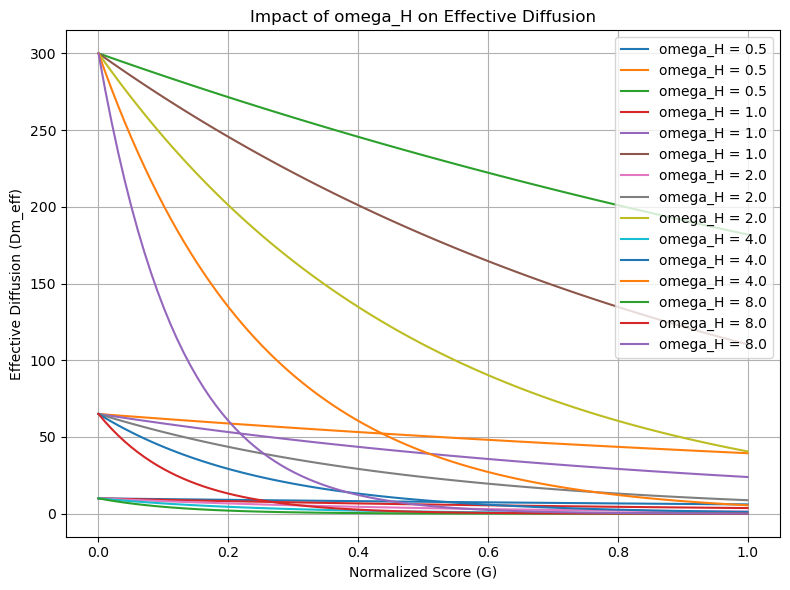

In [8]:
import numpy as np



def compute_norm_score_patch(alpha_HH, H , alpha_HV1 ,V1 , alpha_HV2 ,V2 , alpha_PH, P):

    import numpy as np

    score_G = alpha_HH * H + alpha_HV1 * V1 + alpha_HV2 * V2 + alpha_PH * P

    score_G_min = np.min(score_G)
    score_G_max = np.max(score_G)
    normalized_score_G = (score_G - score_G_min) / (score_G_max - score_G_min + 1e-9)

    return score_G, normalized_score_G


def diff_eq(H, V1, V2, P, dx, dy, sigma_H, eta_H, 
            alpha_HH, alpha_HV1, alpha_HV2, alpha_PH):

    import numpy as np

    omega_H = 2 * sigma_H

    # Use the helper function to compute the G score and its normalized version
    score_G, normalized_score_G = compute_norm_score_patch(
        alpha_HH, H, alpha_HV1, V1, alpha_HV2, V2, alpha_PH, P
    )

    # Use normalized G score to compute effective diffusion
    Dm_eff = np.exp(-omega_H * normalized_score_G) * eta_H


    # Idea provided by chatGPT to encourage movement toward favorable (high-score) areas.
    # alpha = 5

    # Dm_eff = eta_H * (1 + alpha * normalized_score_G)


    # Compute spatial gradients of H
    dHdx = (np.roll(H, -1, axis=0) - np.roll(H, 1, axis=0)) / (2 * dx)
    dHdy = (np.roll(H, -1, axis=1) - np.roll(H, 1, axis=1)) / (2 * dy)

    # Compute fluxes
    flux_x = Dm_eff * dHdx
    flux_y = Dm_eff * dHdy

    # Compute divergence of fluxes
    div_flux_x = (np.roll(flux_x, -1, axis=0) - np.roll(flux_x, 1, axis=0)) / (2 * dx)
    div_flux_y = (np.roll(flux_y, -1, axis=1) - np.roll(flux_y, 1, axis=1)) / (2 * dy)

    divergence = div_flux_x + div_flux_y

    return divergence, score_G, normalized_score_G, Dm_eff


shape = (100, 100)
H = np.random.rand(*shape)
V1 = np.random.rand(*shape)
V2 = np.random.rand(*shape)
P = np.random.rand(*shape)


alpha_vals = np.linspace(0, 10, 5)  # From 0 to 2 in 5 steps

results = []

for alpha_HH in alpha_vals:
    for alpha_HV1 in alpha_vals:
        for alpha_HV2 in alpha_vals:
            for alpha_PH in alpha_vals:
                div, score, norm_score, Dm = diff_eq(
                    H, V1, V2, P, dx=1.0, dy=1.0, sigma_H=1.0, eta_H=1.0,
                    alpha_HH=alpha_HH,
                    alpha_HV1=alpha_HV1,
                    alpha_HV2=alpha_HV2,
                    alpha_PH=alpha_PH
                )
                avg_diff = np.mean(Dm)
                results.append({
                    'alpha_HH': alpha_HH,
                    'alpha_HV1': alpha_HV1,
                    'alpha_HV2': alpha_HV2,
                    'alpha_PH': alpha_PH,
                    'avg_diffusion': avg_diff
                })


import pandas as pd
df = pd.DataFrame(results)
print(df.sort_values('avg_diffusion', ascending=False).head())


import numpy as np
import matplotlib.pyplot as plt

# eta_H = 100.0  # constant diffusion rate
normalized_scores = np.linspace(0, 1, 100)  # score range from 0 to 1

plt.figure(figsize=(8, 6))

for omega_H in [0.5, 1.0, 2.0, 4.0, 8.0]:
    for eta_H in [10, 65, 300]:
        Dm_eff = np.exp(-omega_H * normalized_scores) * eta_H
        plt.plot(normalized_scores, Dm_eff, label=f'omega_H = {omega_H}')

plt.title('Impact of omega_H on Effective Diffusion')
plt.xlabel('Normalized Score (G)')
plt.ylabel('Effective Diffusion (Dm_eff)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


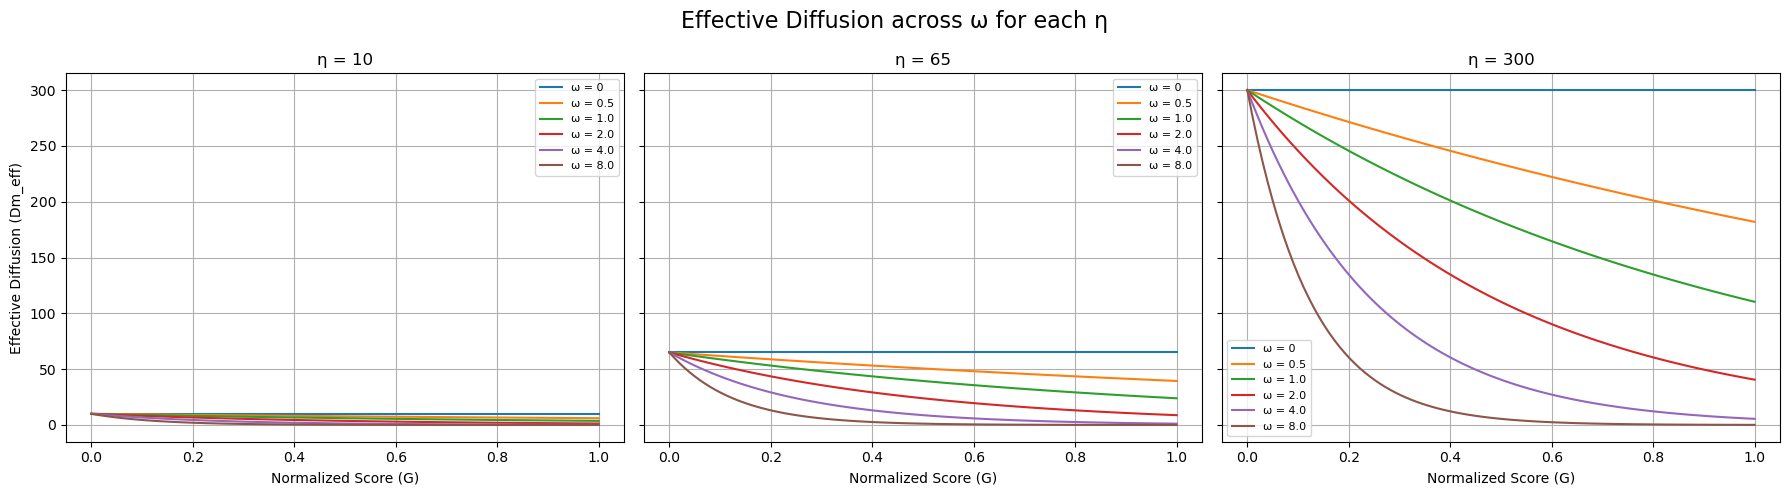

In [15]:
import matplotlib.pyplot as plt
import numpy as np

normalized_scores = np.linspace(0, 1, 100)
omega_H_values = [0, 0.5, 1.0, 2.0, 4.0, 8.0]
eta_H_values = [10, 65, 300]

# Create one subplot per eta_H value
fig, axes = plt.subplots(1, len(eta_H_values), figsize=(18, 5), sharey=True)

for ax, eta_H in zip(axes, eta_H_values):
    for omega_H in omega_H_values:
        Dm_eff = np.exp(-omega_H * normalized_scores) * eta_H
        ax.plot(normalized_scores, Dm_eff, label=f'ω = {omega_H}')
    
    ax.set_title(f'η = {eta_H}')
    ax.set_xlabel('Normalized Score (G)')
    ax.grid(True)
    ax.legend(fontsize=8)

axes[0].set_ylabel('Effective Diffusion (Dm_eff)')
fig.suptitle('Effective Diffusion across ω for each η', fontsize=16)
plt.tight_layout()
plt.show()


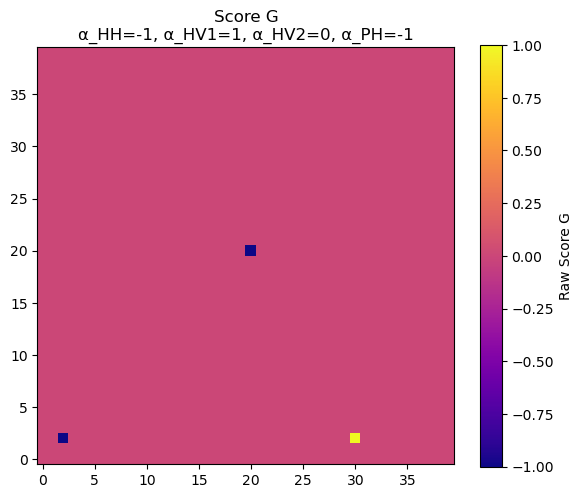

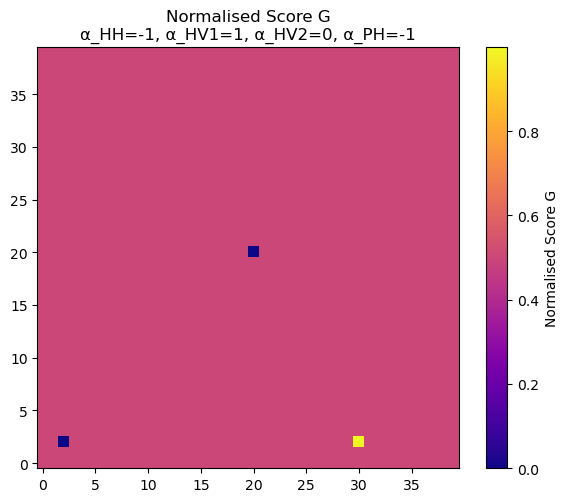

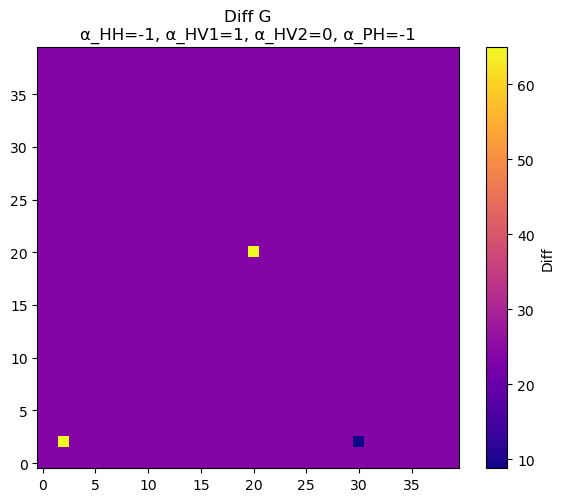

In [13]:
import pandas

import matplotlib.pyplot as plt
import numpy as np

from import_inital_parms import initialize_simulation
model_data = initialize_simulation()

Nx, Ny, dx, dy, dt, Nt, Lx, Ly = model_data["spatial"]
V2_croiss, V1_croiss, k_V2_val, k_V1_norm, k_V2_max = model_data["vegetation"]
V1, V2, H1, H2, P, k_V1, k_V2, mask_V2, mask_V1 = model_data["initial_fields"]
a_H2, a_H1, h_V2H2, e_V1, e_V2, h_V1H1, h_V2H1, h_V1H2, mu_H2, mu_H1, epsi_AJ, chi_H2, chi_H1, a_PH2, a_PH1, h_PH1, h_PH2, mu_P, phi_P, h_P, chi_P, epsi_H1H2, gamma_H1H2, I_H1, I_H2 = model_data["animal_params"]
sigma_H2, sigma_P, alpha_H2H2, alpha_H1H1, alpha_PP, alpha_H2V1, alpha_H2V2, alpha_H1V2, alpha_H1V1, alpha_PH2, alpha_PH1 = model_data["diffusion_params"]
params = model_data["seasonal_functions"]

from Landscape_disturbances_mask import create_barrier_mask
import matplotlib.pyplot as plt

barrier_mask = create_barrier_mask((Nx, Ny), orientation='vertical', thickness=0, position='center')
# Put thickness to 0 to get ride of the barrier

from plot_distribution import plot_initial_species_distribution
from plot_distribution import plot_species_distribution

from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

plot_initial_species_distribution(
    V1, V2, H1, H2, P,
    k_V1, k_V2, barrier_mask,
    Lx, Ly, timestamp,
    plot_species_distribution_fn=plot_species_distribution
)


from diffusion_fct import diff_eq

# Explicit alpha combinations to test
alpha_combinations = [
    {'alpha_HH': -1, 'alpha_HV1': 1, 'alpha_HV2': 0, 'alpha_PH': -1}
    ]

H = H1

results = []

for alpha_set in alpha_combinations:
    div, score_G, norm_score, Dm, diffusion_term, flux_x, flux_y = diff_eq(
        H, V1, V2, P, dx=1.0, dy=1.0, sigma_H=1, eta_H=65,
        alpha_HH=alpha_set['alpha_HH'],
        alpha_HV1=alpha_set['alpha_HV1'],
        alpha_HV2=alpha_set['alpha_HV2'],
        alpha_PH=alpha_set['alpha_PH']
    )
    
    results.append({
        **alpha_set,
        'score_G_mean': np.mean(norm_score),
        'score_G_std': np.std(norm_score),
        'score_G_min': np.min(norm_score),
        'score_G_max': np.max(norm_score)
    })


    plt.figure(figsize=(6, 5))
    plt.imshow(score_G, origin='lower', cmap='plasma')
    plt.colorbar(label='Raw Score G')
    plt.title(f"Score G\nα_HH={alpha_set['alpha_HH']}, α_HV1={alpha_set['alpha_HV1']}, α_HV2={alpha_set['alpha_HV2']}, α_PH={alpha_set['alpha_PH']}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow(norm_score, origin='lower', cmap='plasma')
    plt.colorbar(label='Normalised Score G')
    plt.title(f"Normalised Score G\nα_HH={alpha_set['alpha_HH']}, α_HV1={alpha_set['alpha_HV1']}, α_HV2={alpha_set['alpha_HV2']}, α_PH={alpha_set['alpha_PH']}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow(Dm, origin='lower', cmap='plasma')
    plt.colorbar(label='Diff')
    plt.title(f"Diff G\nα_HH={alpha_set['alpha_HH']}, α_HV1={alpha_set['alpha_HV1']}, α_HV2={alpha_set['alpha_HV2']}, α_PH={alpha_set['alpha_PH']}")
    plt.tight_layout()
    plt.show()

